# 02 Signal Processing Basics
*02 信号処理の基礎*

This notebook covers the fundamentals of signal processing with Wandas. You'll learn how to perform frequency analysis, apply different filters, and visualize results.

*このノートブックではWandasを使った信号処理の基礎を学びます。周波数分析の実行、さまざまなフィルターの適用、結果の可視化方法を習得します。*

## Signal Processing Pipeline
*信号処理パイプライン*

In audio and signal processing, we often apply a sequence of operations to transform and analyze data. Wandas makes this easy with its chaining syntax.

*音声や信号処理では、データを変換し分析するために一連の操作を適用することが一般的です。Wandasではメソッドチェーン構文でこれを簡単に実現できます。*

A typical signal processing pipeline might include:

*一般的な信号処理パイプラインには次のようなステップが含まれます：*

1. **Transform**: Convert time-domain signals to frequency domain using FFT  
   *変換：FFTを使用した時間領域信号の周波数領域への変換*
2. **Filtering**: Remove noise or isolate frequency bands of interest  
   *フィルタリング：ノイズ除去や特定の周波数帯域の分離*
3. **Analysis**: Extract features or measurements from the transformed data  
   *分析：変換されたデータからの特徴や測定値の抽出*
4. **Visualization**: Display results in an interpretable format  
   *可視化：結果を解釈可能な形式で表示*

Let's start with a simple example that demonstrates this workflow.

*このワークフローを示す簡単な例から始めましょう。*

Signal information:
Sampling rate: 44100 Hz
Duration: 1.00 seconds
Shape: (2, 44100) (channels, samples)


<Axes: title={'center': 'Low-Pass Filtered (1kHz) FFT'}, xlabel='Frequency [Hz]', ylabel='Spectrum level [dB]'>

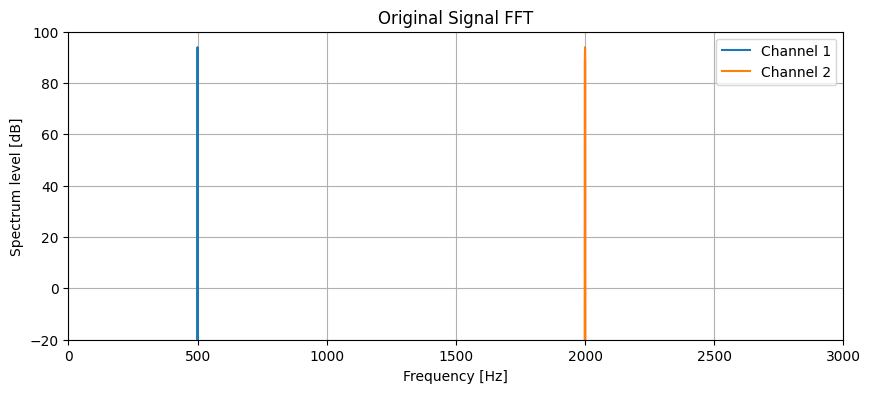

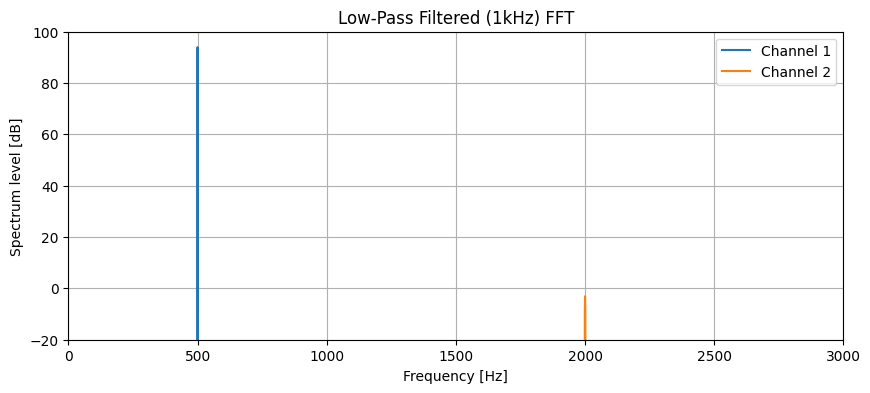

In [1]:
# Import required libraries
# 必要なライブラリをインポート
import wandas as wd
import numpy as np
import matplotlib.pyplot as plt

# Set matplotlib to widget mode for interactive plots
# matplotlibをインタラクティブプロット用のwidgetモードに設定
# %matplotlib widget
plt.rcParams['figure.figsize'] = (10, 4)

# Generate a synthetic signal with two sine waves (500Hz and 2000Hz)
# 2つのサイン波（500Hzと2000Hz）を持つ合成信号を生成
sig = wd.generate_sin(freqs=[500, 2000], duration=1.0, sampling_rate=44100)
# Add units to the signal
# 信号に単位を追加
for cm in sig._channel_metadata:
    cm.unit = "Pa"

# Display basic information about the signal
# 信号の基本情報を表示
print(f"Signal information:")
print(f"Sampling rate: {sig.sampling_rate} Hz")
print(f"Duration: {sig.duration:.2f} seconds")
print(f"Shape: {sig.shape} (channels, samples)")

# Demonstration of signal processing pipeline:
# 1. Apply a low-pass filter (1kHz cutoff)
# 2. Convert to frequency domain with FFT
# 3. Plot the result

# 信号処理パイプラインのデモンストレーション：
# フィルタ処理前後の信号を比較

# ローパスフィルター適用後のFFT
filtered_sig = sig.low_pass_filter(cutoff=1000, order=8)

# プロット
kw = dict(xlim=(0, 3E3), ylim=(-20, 100), overlay=True)
filtered_sig.previous.fft().plot(title='Original Signal FFT', **kw)
filtered_sig.fft().plot(title='Low-Pass Filtered (1kHz) FFT', **kw)

## Frequency Analysis with FFT
*FFTを用いた周波数分析*

The Fast Fourier Transform (FFT) is a fundamental tool in signal processing that converts a time-domain signal into its frequency-domain representation. This transformation reveals the frequency components present in a signal.

*高速フーリエ変換（FFT）は、時間領域の信号を周波数領域の表現に変換する信号処理の基本ツールです。この変換により、信号に含まれる周波数成分が明らかになります。*

Wandas makes frequency analysis simple with its `.fft()` method, which returns a `SpectralFrame` object:

*Wandasの`.fft()`メソッドを使用すると、周波数分析が簡単に行えます。このメソッドは`SpectralFrame`オブジェクトを返します：*

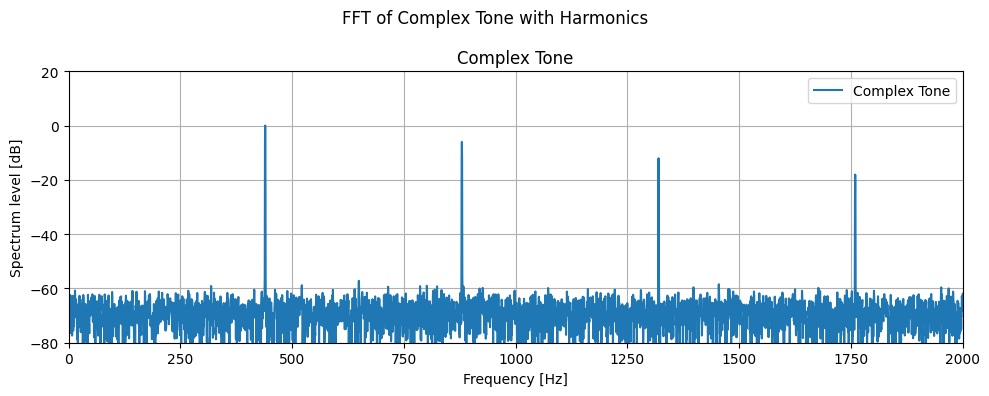


Signal information:
Fundamental frequency: 440 Hz
Harmonics: [440, 880, 1320, 1760] Hz


In [2]:
# Generate a complex test signal with multiple frequencies
# 複数の周波数を持つ複雑なテスト信号を生成
sample_rate = 44100  # Hz
t = np.linspace(0, 2, 2 * sample_rate)  # 2 seconds

# Create a signal with fundamental frequency (440Hz) and harmonics
# 基本周波数（440Hz）と倍音を持つ信号を作成
fundamental = 440  # A4 note (Hz)
harmonics = [fundamental * i for i in range(1, 5)]  # Fundamental + 3 harmonics
amplitudes = [1.0, 0.5, 0.25, 0.125]  # Decreasing amplitudes for harmonics

# Add some noise
# ノイズを追加
np.random.seed(42)  # For reproducibility
complex_signal = np.zeros_like(t)

for freq, amp in zip(harmonics, amplitudes):
    complex_signal += amp * np.sin(2 * np.pi * freq * t)

# Add some noise
noise = 0.05 * np.random.randn(len(t))
complex_signal += noise

# Convert to Wandas ChannelFrame
# Wandas ChannelFrameに変換
complex_cf = wd.from_numpy(complex_signal.reshape(1, -1), sampling_rate=sample_rate, ch_labels=["Complex Tone"])

# Apply FFT
# FFTを適用
spectral_frame = complex_cf.fft(window="hann")

# Plot the FFT
# FFTをプロット
kw = dict(xlim=(0, 2000), ylim=(-80, 20))
spectral_frame.plot(title="FFT of Complex Tone with Harmonics", **kw)

# Print the detected frequencies
# 検出された周波数を表示
print("\nSignal information:")
print(f"Fundamental frequency: {fundamental} Hz")
print(f"Harmonics: {harmonics} Hz")

## Filter Types in Wandas
*Wandasのフィルター種類*

Wandas provides several types of digital filters that are commonly used in signal processing. These filters are implemented using SciPy's signal processing module.

*Wandasは信号処理で一般的に使用されるいくつかのデジタルフィルターを提供しています。これらのフィルターはSciPyの信号処理モジュールを使用して実装されています。*

- **Low-pass filter** (`.low_pass_filter()`): Allows frequencies below the cutoff to pass through  
  *低域通過フィルター：カットオフ周波数より低い周波数を通過させる*
- **High-pass filter** (`.high_pass_filter()`): Allows frequencies above the cutoff to pass through  
  *高域通過フィルター：カットオフ周波数より高い周波数を通過させる*
- **Band-pass filter** (`.band_pass_filter()`): Allows frequencies within a specific range to pass through  
  *帯域通過フィルター：特定の周波数範囲のみを通過させる*

Under the hood, the `.low_pass_filter()` method (and other filter methods) uses **SciPy**'s `signal.iirdesign` to generate IIR (Infinite Impulse Response) filter coefficients.

*裏側では、`.low_pass_filter()`メソッド（および他のフィルターメソッド）は**SciPy**の`signal.iirdesign`を使用してIIR（無限インパルス応答）フィルター係数を生成しています。*

<Axes: title={'center': 'Band-Pass (800Hz-2000Hz)'}, xlabel='Frequency [Hz]', ylabel='Spectrum level [dB]'>

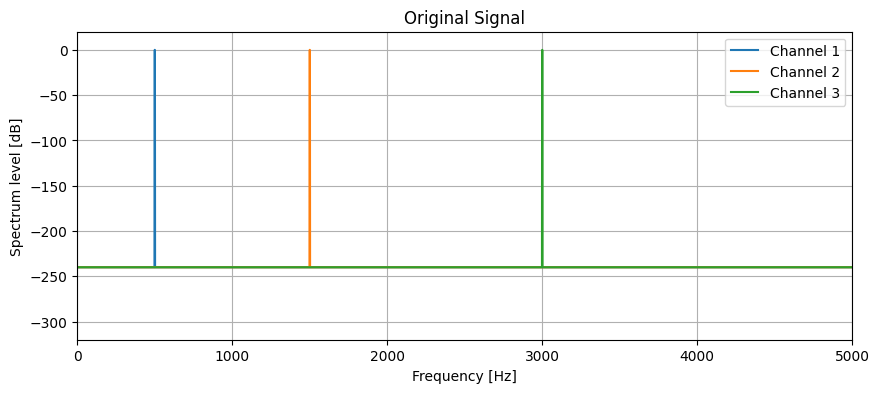

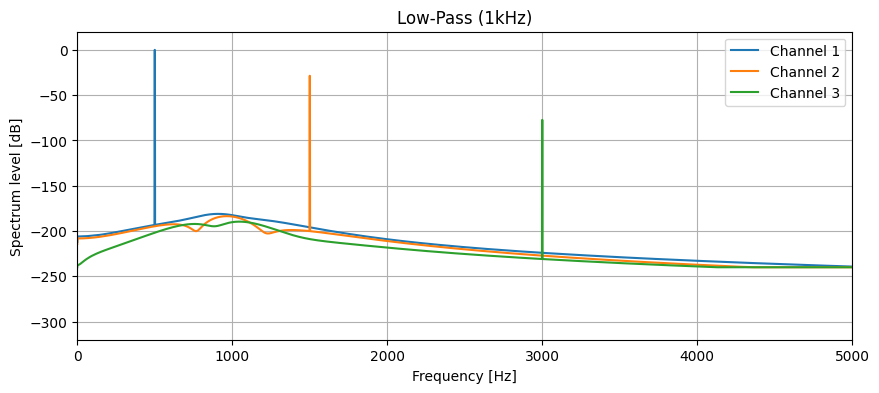

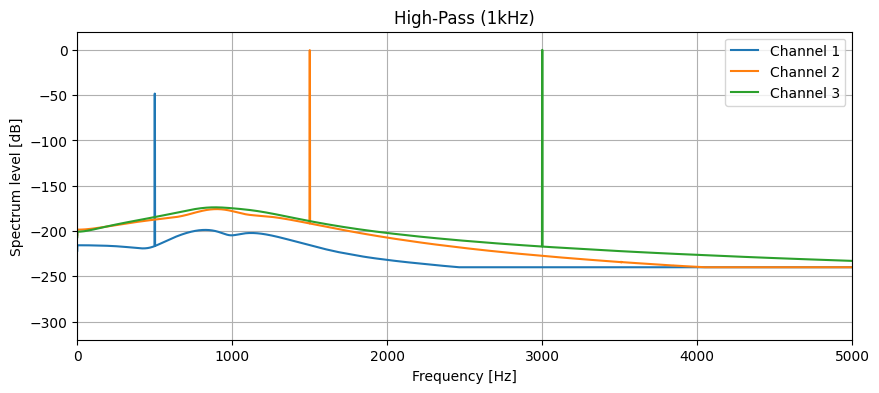

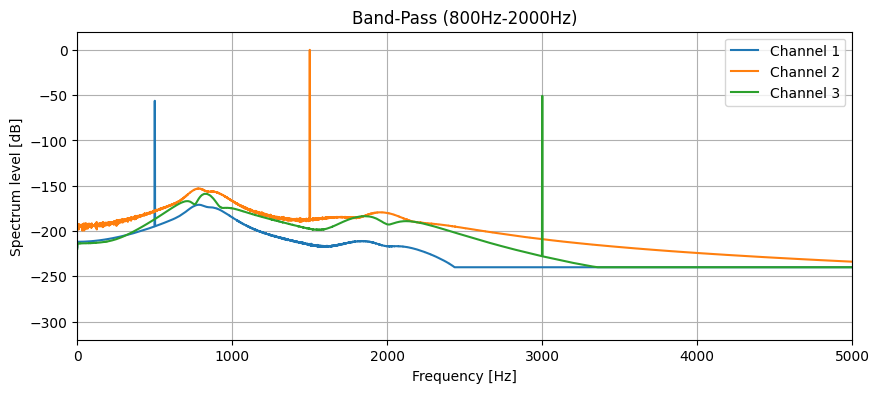

In [3]:
# Compare different filters on the same test signal
# 同じテスト信号に対して異なるフィルターを比較

# Create a multi-frequency test signal (500Hz, 1500Hz, and 3000Hz)
# 複数の周波数（500Hz、1500Hz、3000Hz）を持つテスト信号を作成
test_signal = wd.generate_sin(freqs=[500, 1500, 3000], duration=1.0, sampling_rate=44100)

# Compare original and filtered signals in frequency domain
# 元の信号とフィルター後の信号を周波数領域で比較
kw = dict(xlim=(0, 5E3), ylim=(-320, 20), overlay=True)

# Original signal FFT
# 元の信号のFFT
test_signal.fft().plot(title='Original Signal', **kw)

# Low-pass filter (1kHz)
# 低域通過フィルター（1kHz）
test_signal.low_pass_filter(cutoff=1000).fft().plot(title='Low-Pass (1kHz)', **kw)

# High-pass filter (1kHz)
# 高域通過フィルター（1kHz）
test_signal.high_pass_filter(cutoff=1000).fft().plot(title='High-Pass (1kHz)', **kw)

# Band-pass filter (800Hz-2000Hz)
# 帯域通過フィルター（800Hz-2000Hz）
test_signal.band_pass_filter(low_cutoff=800, high_cutoff=2000).fft().plot(title='Band-Pass (800Hz-2000Hz)', **kw)

## Practical Example: Audio Equalizer
*実用的な例：オーディオイコライザー*

Let's create a simple audio equalizer by applying different filters to different frequency bands of an audio signal.

*オーディオ信号の異なる周波数帯域に異なるフィルターを適用して、簡単なオーディオイコライザーを作成しましょう。*

<Axes: title={'center': 'Treble Boost'}, xlabel='Frequency [Hz]', ylabel='Spectrum level [dB]'>

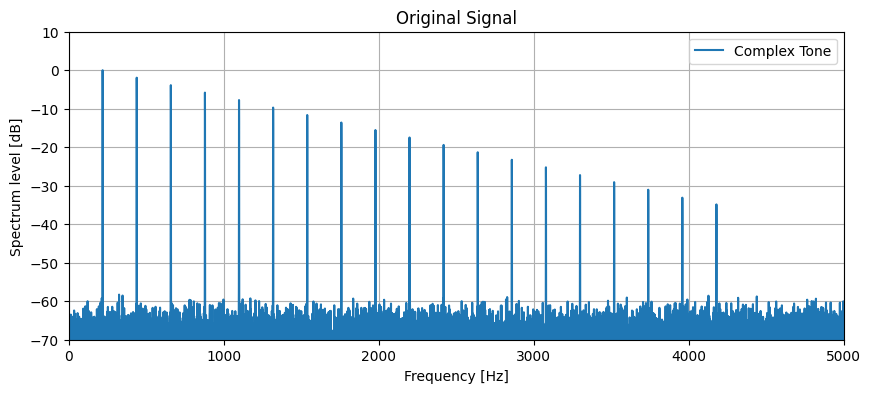

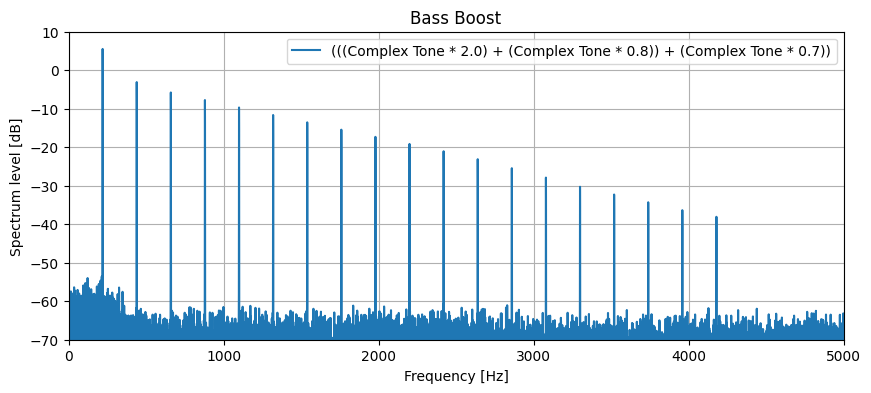

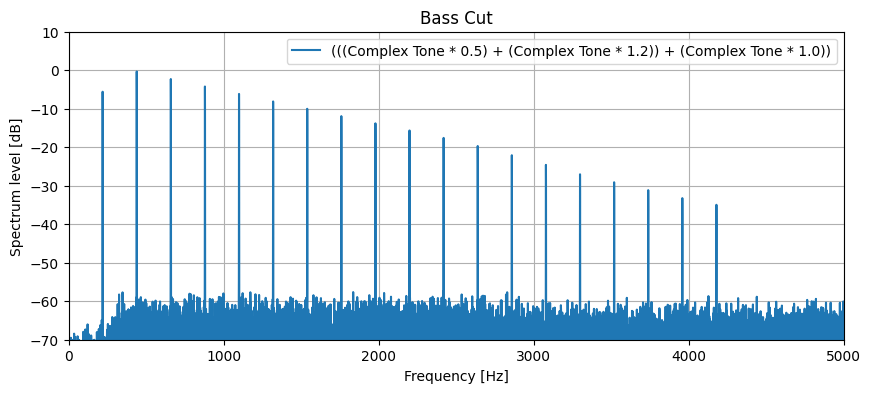

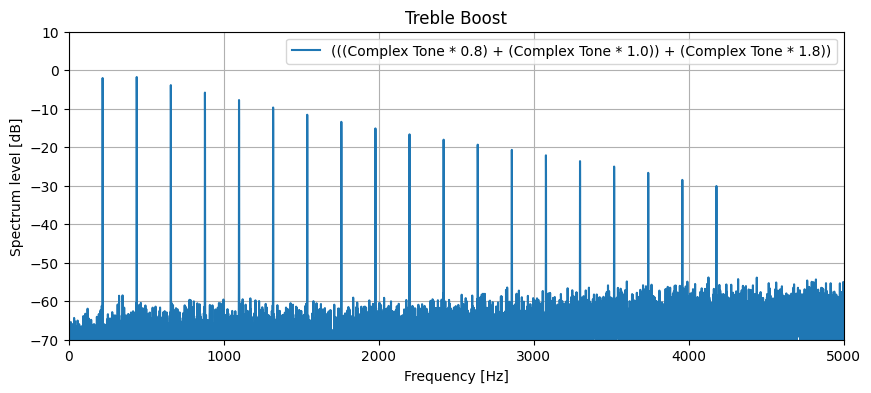

In [4]:
# Create a function to simulate an audio equalizer
# オーディオイコライザーをシミュレートする関数を作成
def apply_equalizer(signal, bass_gain=1.0, mid_gain=1.0, treble_gain=1.0):
    """
    Apply a 3-band equalizer to a signal.

    Parameters:
    - signal: A ChannelFrame object
    - bass_gain: Gain for low frequencies (0-300Hz)
    - mid_gain: Gain for mid frequencies (300Hz-3kHz)
    - treble_gain: Gain for high frequencies (3kHz+)

    Returns:
    - ChannelFrame with equalization applied
    """
    # Split the signal into frequency bands
    bass = signal.low_pass_filter(cutoff=300)
    mid = signal.band_pass_filter(low_cutoff=300, high_cutoff=3000)
    treble = signal.high_pass_filter(cutoff=3000)

    # Apply gains
    bass_adj = bass * bass_gain
    mid_adj = mid * mid_gain
    treble_adj = treble * treble_gain

    # Combine the bands
    return bass_adj + mid_adj + treble_adj

# Generate a complex test signal with multiple frequencies
# 複数の周波数を持つ複雑なテスト信号を生成
sample_rate = 44100  # Hz
t = np.linspace(0, 2, 2 * sample_rate)  # 2 seconds

# Create a signal with fundamental frequency (220Hz) and harmonics
# 基本周波数（220Hz）と倍音を持つ信号を作成
fundamental = 220  # A3 note (Hz)
harmonics = [fundamental * i for i in range(1, 20)]  # Fundamental + harmonics
signal = np.zeros_like(t)

# Add harmonics with decreasing amplitude
# 減少する振幅で倍音を追加
for i, freq in enumerate(harmonics):
    signal += (0.8 ** i) * np.sin(2 * np.pi * freq * t)

# Add some noise
# ノイズを追加
noise = 0.05 * np.random.randn(len(t))
signal += noise

# Convert to Wandas ChannelFrame
# Wandas ChannelFrameに変換
complex_cf = wd.from_numpy(signal.reshape(1, -1), sampling_rate=sample_rate, ch_labels=["Complex Tone"])

# Create different EQ settings
# 異なるイコライザー設定を作成
bass_boost = apply_equalizer(complex_cf, bass_gain=2.0, mid_gain=0.8, treble_gain=0.7)
bass_cut = apply_equalizer(complex_cf, bass_gain=0.5, mid_gain=1.2, treble_gain=1.0)
treble_boost = apply_equalizer(complex_cf, bass_gain=0.8, mid_gain=1.0, treble_gain=1.8)

# Visualize the frequency response of each setting
# 各設定の周波数応答を可視化
kw = dict(xlim=(0, 5000), ylim=(-70, 10), overlay=True)

# Plot the spectra
# スペクトルをプロット
complex_cf.fft().plot(title='Original Signal', **kw)
bass_boost.fft().plot(title='Bass Boost', **kw)
bass_cut.fft().plot(title='Bass Cut', **kw)
treble_boost.fft().plot(title='Treble Boost', **kw)

## Summary
*まとめ*

In this notebook, we've explored the fundamentals of signal processing with Wandas:

*このノートブックでは、Wandasを使った信号処理の基礎を探索しました：*

- Performed frequency analysis using FFT  
  *FFTを使用した周波数分析を実行*
- Applied different types of filters (low-pass, high-pass, band-pass)  
  *さまざまなタイプのフィルター（低域通過、高域通過、帯域通過）を適用*
- Extracted spectral features from signals  
  *信号からスペクトル特徴を抽出*
- Created a simple audio equalizer  
  *簡単なオーディオイコライザーを作成*

Wandas's chaining syntax makes it easy to create complex signal processing pipelines in a readable and maintainable way. This approach allows for rapid experimentation and development of audio processing applications.

*Wandasのメソッドチェーン構文を使うと、複雑な信号処理パイプラインを読みやすく、維持管理しやすい方法で作成できます。このアプローチにより、オーディオ処理アプリケーションの迅速な実験と開発が可能になります。*

## Next Steps
*次のステップ*

In the next notebook, we'll explore more advanced visualization techniques to help you better understand and analyze your signal data.

*次のノートブックでは、信号データをより理解し分析するための高度な可視化テクニックを探索します。*

**Next notebook**: [03_visualization.ipynb](./03_visualization.ipynb)  
*次のノートブック： [03_visualization.ipynb](./03_visualization.ipynb)*